### Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
import pandasql.sqldf as sqldf
import seaborn as sns
import matplotlib.pyplot as plt

## Data Processing

#### Train Data

In [2]:
df_train_ = pd.read_csv('train_FD001.csv')
df_train_.head()

,ENGINE_NUMBER,TIME_IN_CYCLES,SETTING_1,SETTING_2,TRA,T2,T24,T30,T50,P2,...,NRF,NRC,BPR,FARB,HTBLEED,NF_DMD,PCNFR_DMD,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


#### Test Data

In [3]:
df_test_ = pd.read_csv('test_FD001.csv')
df_test_.head()

,ENGINE_NUMBER,TIME_IN_CYCLES,SETTING_1,SETTING_2,TRA,T2,T24,T30,T50,P2,...,PHI,NRF,NRC,BPR,FARB,HTBLEED,NF_DMD,PCNFR_DMD,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


#### Plot the correlation graph showing the relation between variables

<AxesSubplot:>

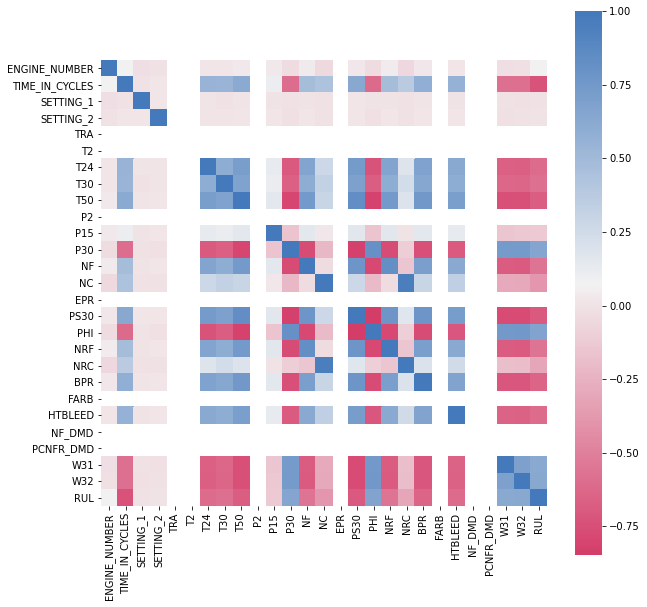

In [4]:
f, ax = plt.subplots(figsize=(10, 10))
corr = df_train_.corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(0, 250, as_cmap=True),
            square=True, ax=ax)

#### Plot the correlation matrix showing the relation between variables with values

In [5]:
corr = df_train_.corr()
corr.style.background_gradient(cmap=plt.cm.rainbow, vmin = None, vmax = None)

C:\Users\MNTM\anaconda3\lib\site-packages\pandas\io\formats\style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
C:\Users\MNTM\anaconda3\lib\site-packages\pandas\io\formats\style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,ENGINE_NUMBER,TIME_IN_CYCLES,SETTING_1,SETTING_2,TRA,T2,T24,T30,T50,P2,P15,P30,NF,NC,EPR,PS30,PHI,NRF,NRC,BPR,FARB,HTBLEED,NF_DMD,PCNFR_DMD,W31,W32,RUL
ENGINE_NUMBER,1.000000,0.078753,-0.017895,-0.006197,nan,nan,0.014133,0.012621,0.026116,nan,0.026431,-0.032073,0.039929,-0.052053,nan,0.024707,-0.031882,0.044230,-0.059473,0.022486,nan,0.013513,nan,nan,-0.020589,-0.016465,0.078753
TIME_IN_CYCLES,0.078753,1.000000,-0.004527,0.016132,nan,nan,0.549898,0.543947,0.624577,nan,0.105980,-0.595914,0.475977,0.443999,nan,0.634385,-0.611354,0.477523,0.370324,0.588676,nan,0.566995,nan,nan,-0.583597,-0.585923,-0.736241
SETTING_1,-0.017895,-0.004527,1.000000,0.011660,nan,nan,0.009030,-0.005651,0.009544,nan,-0.001340,-0.009437,-0.000427,-0.004279,nan,0.011658,-0.001491,0.002318,-0.004469,0.007652,nan,0.002599,nan,nan,-0.005713,-0.014559,-0.003198
SETTING_2,-0.006197,0.016132,0.011660,1.000000,nan,nan,0.007266,0.009068,0.014673,nan,0.014355,-0.016678,0.013285,-0.005425,nan,0.011690,-0.010923,0.018156,-0.006310,0.014156,nan,0.012280,nan,nan,-0.010554,-0.007846,-0.001948
TRA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
T24,0.014133,0.549898,0.009030,0.007266,nan,nan,1.000000,0.602610,0.714949,nan,0.132242,-0.702136,0.662325,0.273764,nan,0.740020,-0.724578,0.661792,0.179752,0.675975,nan,0.629886,nan,nan,-0.661841,-0.668050,-0.606484
T30,0.012621,0.543947,-0.005651,0.009068,nan,nan,0.602610,1.000000,0.678413,nan,0.116039,-0.664595,0.602481,0.322964,nan,0.695900,-0.680307,0.600963,0.237137,0.639921,nan,0.600017,nan,nan,-0.625941,-0.633901,-0.584520
T50,0.026116,0.624577,0.009544,0.014673,nan,nan,0.714949,0.678413,1.000000,nan,0.150480,-0.793130,0.746852,0.297429,nan,0.830136,-0.815591,0.745158,0.190748,0.758459,nan,0.703499,nan,nan,-0.748067,-0.745193,-0.678948
P2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Note:
        
    1. It is clear from the above matrix that 'ENGINE_NUMBER', 'SETTING_1', 'SETTING_2' have very negligible
       correlation with 'RUL'. So, we must drop these features.
        
    2. Since, features like 'TRA', 'T2', 'P2', 'EPR', 'FARB', 'NF_DMD', 'PCNFR_DMD' have NaN values, we must
       drop these features. If we look at the data, these features do not change with time and are constants.
      
    3. Remove all the above features except 'ENGINE_NUMBER'. After splitting to Train-Valid-Test Set,
       we remove 'ENGINE NUMBER'

#### Look at the shape of the dataframes

In [6]:
print('Shape Train: ', df_train_.shape)
print('Shape Test: ', df_test_.shape)

Shape Train:  (20631, 27)
Shape Test:  (13096, 26)


#### Read the RUL dataframe of test data

In [7]:
df_rul = pd.read_csv('RUL_FD001.csv', header = None)
print('Shape RUL Test: ', df_rul.shape)

Shape RUL Test:  (100, 1)


### Remove features which do not influence the model

In [8]:
COLUMNSTOREMOVE = ['SETTING_1'       # NO INFLUENCE TO MODEL   ]
                , 'SETTING_2'             # NO INFLUENCE TO MODEL  
                , "TRA"                   # NO INFLUENCE TO MODEL  
                , "T2"                    # NO INFLUENCE TO MODEL  
                , "P2"                    # NO INFLUENCE TO MODEL  
                , "EPR"                   # NO INFLUENCE TO MODEL  
                , "FARB"                  # NO INFLUENCE TO MODEL  
                , "NF_DMD"                # NO INFLUENCE TO MODEL  
                , "PCNFR_DMD"             # NO INFLUENCE TO MODEL  
              ]

In [9]:
df_train_0 = df_train_.drop(labels = COLUMNSTOREMOVE, axis = 1, inplace = False)
df_test = df_test_.drop(labels = COLUMNSTOREMOVE, axis = 1, inplace = False)

In [10]:
print('Shape Train: ', df_train_0.shape)
print('Shape Test: ', df_test.shape)

Shape Train:  (20631, 18)
Shape Test:  (13096, 17)


### Prepare the Train-Valid-Test Data

In [11]:
# Get Column Names of Train
col = df_train_0.columns
col

Index(['ENGINE_NUMBER', 'TIME_IN_CYCLES', 'T24', 'T30', 'T50', 'P15', 'P30',
       'NF', 'NC', 'PS30', 'PHI', 'NRF', 'NRC', 'BPR', 'HTBLEED', 'W31', 'W32',
       'RUL'],
      dtype='object')

In [12]:
# Get Column Names of Test
col_test = df_test.columns
col_test

Index(['ENGINE_NUMBER', 'TIME_IN_CYCLES', 'T24', 'T30', 'T50', 'P15', 'P30',
       'NF', 'NC', 'PS30', 'PHI', 'NRF', 'NRC', 'BPR', 'HTBLEED', 'W31',
       'W32'],
      dtype='object')

### Make Train Test DataFrames
        
        1. Split the original train set to 80% Training Set, 15% Validation Set and 5 % Test set.

In [13]:
df_train = sqldf('SELECT * FROM df_train_0 WHERE `ENGINE_NUMBER` <= 80')  # Train set
df_valid = sqldf('SELECT * FROM df_train_0 WHERE `ENGINE_NUMBER` BETWEEN 81 AND 95')  # Validation Set
df_test_dummy = sqldf('SELECT * FROM df_train_0 WHERE `ENGINE_NUMBER` BETWEEN 96 AND 100') # Test Set

In [14]:
# Feature Variables
trainX = df_train[col[col!='RUL']]
validX = df_valid[col[col!='RUL']]
test_X_0 = df_test_dummy[col[col!='RUL']] # For Predicting
testX = df_test[col_test[col_test!='RUL']] # For Final Test

# Target Variables
trainY = df_train['RUL']
validY = df_valid['RUL']
testY = df_test_dummy['RUL']  # For Predicting

# Drop 'ENGINE NUMBER' from Train and Valid Dataset
trainX = trainX.drop(labels = 'ENGINE_NUMBER', axis = 1, inplace = False)
validX = validX.drop(labels = 'ENGINE_NUMBER', axis = 1, inplace = False)
test_X_0 = test_X_0.drop(labels = 'ENGINE_NUMBER', axis = 1, inplace = False) # For Predicting

# Print Shapes
print('Train X Shape: ', trainX.shape)
print('Valid X Shape: ', validX.shape)

Train X Shape:  (16138, 16)
Valid X Shape:  (3414, 16)


### Convert to Numpy Arrays

In [15]:
# Train Data
trainX = np.asarray(trainX, dtype = float)
trainY = np.asarray(trainY, dtype = float)

# Valid Data
validX = np.asarray(validX, dtype = float)
validY = np.asarray(validY, dtype = float)

# Test Data
test_X_0 = np.asarray(test_X_0, dtype = float)
testY = np.asarray(testY, dtype = float)

### Normalize Data

In [16]:
trainX = minmax_scale(trainX)
validX = minmax_scale(validX)
test_X_0 = minmax_scale(test_X_0)

In [17]:
print('Train X: ', trainX.shape)
print('Valid X: ', validX.shape)
print('Test X: ', test_X_0.shape)
print('Train Y: ', trainY.shape)
print('Valid Y: ', validY.shape)
print('Test Y: ', testY.shape)

Train X:  (16138, 16)
Valid X:  (3414, 16)
Test X:  (1079, 16)
Train Y:  (16138,)
Valid Y:  (3414,)
Test Y:  (1079,)


### Prepare for 1D Convolve-LSTM Input

##### CONVOLUTION INPUT:
         1. Conv1D layer expects input shape in 3D as
                 [batch_size, time_steps, input_dimension]
                 
         2. However, current data is in the shape of
                 [batch_size, features]
         
         3. Reshape the Data with the Sensor Measurements as Time Steps i.e. features to Time Steps
         
         4. Eg: (20631, 17) to (20631, 17, 1)
         
##### LSTM INPUT:
         1. LSTM layer expects input shape in 3D as
                 [batch_size, time_steps, input_dimension]
                 
         2. However, current data is in the shape of
                 [batch_size, features]
         
         3. Reshape the Data with the Sensor Measurements as input_dimensions i.e. features to input_dimensions
         
         4. Eg: (20631, 17) to (20631, 1, 17)
         

In [18]:
sample_size = trainX.shape[0]
time_steps = trainX.shape[1]
input_dimension = 1
print('Sizes: ', sample_size, time_steps, input_dimension)

Sizes:  16138 16 1


#### CNN Input

In [19]:
trainX_CNN = trainX.reshape(sample_size, time_steps, input_dimension)
validX_CNN = validX.reshape(validX.shape[0], time_steps, input_dimension)
testX_CNN = test_X_0.reshape(test_X_0.shape[0], time_steps, input_dimension)

In [20]:
print('Reshaped TrainX: ', trainX_CNN.shape)
print('Reshaped ValidX: ', validX_CNN.shape)
print('Reshaped TestX: ', testX_CNN.shape)
print('Sample:', trainX_CNN[0])

Reshaped TrainX:  (16138, 16, 1)
Reshaped ValidX:  (3414, 16, 1)
Reshaped TestX:  (1079, 16, 1)
Sample: [[0.        ]
 [0.18373494]
 [0.42515379]
 [0.30975692]
 [1.        ]
 [0.72624799]
 [0.24242424]
 [0.109755  ]
 [0.36526946]
 [0.63326226]
 [0.20588235]
 [0.1996078 ]
 [0.36398615]
 [0.36363636]
 [0.70866142]
 [0.72548186]]


#### LSTM Input

In [21]:
trainX_LSTM = trainX.reshape(sample_size, input_dimension, time_steps)
validX_LSTM = validX.reshape(validX.shape[0], input_dimension, time_steps)
testX_LSTM = test_X_0.reshape(test_X_0.shape[0], input_dimension, time_steps)

In [22]:
print('Reshaped TrainX: ', trainX_LSTM.shape)
print('Reshaped ValidX: ', validX_LSTM.shape)
print('Reshaped TestX: ', testX_LSTM.shape)
print('Sample:', trainX_LSTM[0])

Reshaped TrainX:  (16138, 1, 16)
Reshaped ValidX:  (3414, 1, 16)
Reshaped TestX:  (1079, 1, 16)
Sample: [[0.         0.18373494 0.42515379 0.30975692 1.         0.72624799
  0.24242424 0.109755   0.36526946 0.63326226 0.20588235 0.1996078
  0.36398615 0.36363636 0.70866142 0.72548186]]


### The 1D Convolution Network

In [23]:
n_timesteps = trainX_CNN.shape[1] # 16
n_features = trainX_CNN.shape[2]  # 1 
print(n_timesteps, n_features)

16 1


In [24]:
CNN = tf.keras.layers.Input(shape = (n_timesteps, n_features), name = 'CNN_INPUT')

CNN_layer_C1 = tf.keras.layers.Conv1D(filters = 128, activation = 'relu', kernel_size = 3 , name = '1D-CONV1')(CNN)
CNN_layer_P1 = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', strides = 2, name = 'POOL1')(CNN_layer_C1)
CNN_layer_B1 = tf.keras.layers.BatchNormalization(name = 'BN1')(CNN_layer_P1)

CNN_layer_C2 = tf.keras.layers.Conv1D(filters = 64, activation = 'relu', kernel_size = 3, name = '1D-CONV2')(CNN_layer_B1)
CNN_layer_P2 = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', strides = 2, name = 'POOL2')(CNN_layer_C2)
CNN_layer_B2 = tf.keras.layers.BatchNormalization(name = 'BN2')(CNN_layer_P2)

CNN_layer_C3 = tf.keras.layers.Conv1D(filters = 32, activation = 'relu', kernel_size = 3,  name = '1D-CONV3')(CNN_layer_B2)
CNN_layer_P2 = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = 'same', strides = 2, name = 'POOL3')(CNN_layer_C3)

### The LSTM Network

In [25]:
LSTM = tf.keras.layers.Input(shape = (n_features, n_timesteps), name = 'LSTM_INPUT')
LSTM_1 = tf.keras.layers.LSTM(128,  return_sequences = True, name = 'LSTM1')(LSTM)
LSTM_2 = tf.keras.layers.LSTM(64 ,  return_sequences = True, name = 'LSTM2')(LSTM_1)
LSTM_3 = tf.keras.layers.LSTM(32 ,  return_sequences = True, name = 'LSTM3')(LSTM_2)

### Concatenate Networks

In [26]:
CNN_LSTM = tf.keras.layers.concatenate([CNN_layer_P2, LSTM_3], name = 'CONCATENATION_LAYER')

### Fully Connected Layers

In [27]:
CNN_FC_C1 = tf.keras.layers.Conv1D(filters = 256, kernel_size = 1, name = 'CONVOLUTION')(CNN_LSTM)
CNN_FC_P1 = tf.keras.layers.MaxPool1D(pool_size = 2, padding = 'same', strides = 2, name = 'POOLING')(CNN_FC_C1)
FCN_flatten = tf.keras.layers.Flatten(name = 'FLATTEN_LAYER')(CNN_FC_P1)
FCN_layer1 = tf.keras.layers.Dense(128, activation = 'relu', name = 'DENSE1')(FCN_flatten)
FCN_D1 = tf.keras.layers.Dropout(0.3)
FCN_layer2 = tf.keras.layers.Dense(32,  activation = 'relu', name = 'DENSE2')(FCN_layer1)
FCN_out = tf.keras.layers.Dense(1, name = 'RUL')(FCN_layer2)

### Define Custom Loss -RMSE

In [28]:
class RMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, y_true, y_pred):
        rmse = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(y_pred, y_true)))
        return rmse

### Create Final Model

In [29]:
model = tf.keras.Model(inputs = [CNN, LSTM], outputs = FCN_out, name = 'FC_CNN_LSTM')
model.compile(loss =RMSE(), optimizer = tf.keras.optimizers.Adam(), metrics = [tf.keras.metrics.RootMeanSquaredError()])

### Summarize Model

In [30]:
model.summary()

Model: "FC_CNN_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN_INPUT (InputLayer)          [(None, 16, 1)]      0                                            
__________________________________________________________________________________________________
1D-CONV1 (Conv1D)               (None, 14, 128)      512         CNN_INPUT[0][0]                  
__________________________________________________________________________________________________
POOL1 (MaxPooling1D)            (None, 7, 128)       0           1D-CONV1[0][0]                   
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 7, 128)       512         POOL1[0][0]                      
________________________________________________________________________________________

### Plot Model Graph

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Create Early Stopping Callback and CSV Logger

In [31]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience =50, mode = 'auto')
csv_logger = 'Training_Metrics.csv'

### Fit Model

In [33]:
history = model.fit(x = [trainX_CNN, trainX_LSTM], batch_size = 256, y = trainY, epochs = 600, 
                    validation_data=([validX_CNN, validX_LSTM], validY), verbose = 1,
                   callbacks =[tf.keras.callbacks.CSVLogger(csv_logger)])

Epoch 1/600
64/64 [==============================] - 7s 35ms/step - loss: 56.1184 - root_mean_squared_error: 63.8990 - val_loss: 128.4715 - val_root_mean_squared_error: 133.0822
Epoch 2/600
64/64 [==============================] - 1s 17ms/step - loss: 33.6487 - root_mean_squared_error: 33.7819 - val_loss: 117.0060 - val_root_mean_squared_error: 121.9941
Epoch 3/600
64/64 [==============================] - 1s 16ms/step - loss: 32.9677 - root_mean_squared_error: 33.0936 - val_loss: 107.3799 - val_root_mean_squared_error: 112.6862
Epoch 4/600
64/64 [==============================] - 1s 17ms/step - loss: 32.7385 - root_mean_squared_error: 32.8545 - val_loss: 100.6197 - val_root_mean_squared_error: 106.1171
Epoch 5/600
64/64 [==============================] - 1s 17ms/step - loss: 32.7469 - root_mean_squared_error: 32.8626 - val_loss: 92.8368 - val_root_mean_squared_error: 98.5905
Epoch 6/600
64/64 [==============================] - 1s 17ms/step - loss: 32.6893 - root_mean_squared_error: 32.

64/64 [==============================] - 1s 17ms/step - loss: 30.6606 - root_mean_squared_error: 30.7472 - val_loss: 48.2254 - val_root_mean_squared_error: 54.2317
Epoch 94/600
64/64 [==============================] - 1s 17ms/step - loss: 30.5065 - root_mean_squared_error: 30.6244 - val_loss: 49.9776 - val_root_mean_squared_error: 56.2131
Epoch 95/600
64/64 [==============================] - 1s 17ms/step - loss: 30.4744 - root_mean_squared_error: 30.5481 - val_loss: 51.2633 - val_root_mean_squared_error: 56.7660
Epoch 96/600
64/64 [==============================] - 1s 17ms/step - loss: 30.4833 - root_mean_squared_error: 30.5652 - val_loss: 51.3212 - val_root_mean_squared_error: 56.8976
Epoch 97/600
64/64 [==============================] - 1s 16ms/step - loss: 30.5193 - root_mean_squared_error: 30.6258 - val_loss: 52.4908 - val_root_mean_squared_error: 58.6033
Epoch 98/600
64/64 [==============================] - 1s 16ms/step - loss: 30.4240 - root_mean_squared_error: 30.5464 - val_loss

64/64 [==============================] - 1s 16ms/step - loss: 28.0771 - root_mean_squared_error: 28.1358 - val_loss: 50.6902 - val_root_mean_squared_error: 56.2620
Epoch 186/600
64/64 [==============================] - 1s 16ms/step - loss: 27.6047 - root_mean_squared_error: 27.7177 - val_loss: 48.5626 - val_root_mean_squared_error: 53.6106
Epoch 187/600
64/64 [==============================] - 1s 16ms/step - loss: 27.8823 - root_mean_squared_error: 27.9846 - val_loss: 50.2438 - val_root_mean_squared_error: 55.4082
Epoch 188/600
64/64 [==============================] - 1s 16ms/step - loss: 27.8882 - root_mean_squared_error: 27.9893 - val_loss: 51.4230 - val_root_mean_squared_error: 57.1153
Epoch 189/600
64/64 [==============================] - 1s 16ms/step - loss: 27.6363 - root_mean_squared_error: 27.7284 - val_loss: 49.6049 - val_root_mean_squared_error: 55.0079
Epoch 190/600
64/64 [==============================] - 1s 16ms/step - loss: 27.5541 - root_mean_squared_error: 27.6386 - val

64/64 [==============================] - 1s 16ms/step - loss: 25.4110 - root_mean_squared_error: 25.5081 - val_loss: 51.9918 - val_root_mean_squared_error: 56.4843
Epoch 278/600
64/64 [==============================] - 1s 17ms/step - loss: 24.0587 - root_mean_squared_error: 24.1298 - val_loss: 50.9962 - val_root_mean_squared_error: 56.0362
Epoch 279/600
64/64 [==============================] - 1s 16ms/step - loss: 23.6945 - root_mean_squared_error: 23.7634 - val_loss: 50.6955 - val_root_mean_squared_error: 55.5264
Epoch 280/600
64/64 [==============================] - 1s 16ms/step - loss: 23.6461 - root_mean_squared_error: 23.7122 - val_loss: 51.0218 - val_root_mean_squared_error: 56.2345
Epoch 281/600
64/64 [==============================] - 1s 17ms/step - loss: 24.3345 - root_mean_squared_error: 24.4149 - val_loss: 50.2936 - val_root_mean_squared_error: 54.5665
Epoch 282/600
64/64 [==============================] - 1s 16ms/step - loss: 24.8253 - root_mean_squared_error: 24.9110 - val

64/64 [==============================] - 1s 16ms/step - loss: 20.6956 - root_mean_squared_error: 20.7521 - val_loss: 51.6819 - val_root_mean_squared_error: 56.5582
Epoch 370/600
64/64 [==============================] - 1s 17ms/step - loss: 20.5217 - root_mean_squared_error: 20.5644 - val_loss: 51.2294 - val_root_mean_squared_error: 55.9441
Epoch 371/600
64/64 [==============================] - 1s 16ms/step - loss: 20.9673 - root_mean_squared_error: 21.0200 - val_loss: 50.9884 - val_root_mean_squared_error: 55.7330
Epoch 372/600
64/64 [==============================] - 1s 17ms/step - loss: 20.7547 - root_mean_squared_error: 20.8040 - val_loss: 52.3025 - val_root_mean_squared_error: 56.5185
Epoch 373/600
64/64 [==============================] - 1s 17ms/step - loss: 24.4890 - root_mean_squared_error: 24.6441 - val_loss: 53.3830 - val_root_mean_squared_error: 58.0534
Epoch 374/600
64/64 [==============================] - 1s 17ms/step - loss: 21.9323 - root_mean_squared_error: 22.0033 - val

64/64 [==============================] - 1s 17ms/step - loss: 18.1998 - root_mean_squared_error: 18.2362 - val_loss: 56.6737 - val_root_mean_squared_error: 61.2956
Epoch 462/600
64/64 [==============================] - 1s 17ms/step - loss: 18.6609 - root_mean_squared_error: 18.7139 - val_loss: 54.3990 - val_root_mean_squared_error: 59.5390
Epoch 463/600
64/64 [==============================] - 1s 17ms/step - loss: 18.7709 - root_mean_squared_error: 18.8296 - val_loss: 54.9660 - val_root_mean_squared_error: 59.9537
Epoch 464/600
64/64 [==============================] - 1s 17ms/step - loss: 18.2785 - root_mean_squared_error: 18.3202 - val_loss: 53.5745 - val_root_mean_squared_error: 58.1734
Epoch 465/600
64/64 [==============================] - 1s 17ms/step - loss: 18.3317 - root_mean_squared_error: 18.3668 - val_loss: 53.3926 - val_root_mean_squared_error: 57.8419
Epoch 466/600
64/64 [==============================] - 1s 17ms/step - loss: 18.3257 - root_mean_squared_error: 18.3607 - val

64/64 [==============================] - 1s 16ms/step - loss: 17.2363 - root_mean_squared_error: 17.2934 - val_loss: 54.7263 - val_root_mean_squared_error: 58.8548
Epoch 554/600
64/64 [==============================] - 1s 17ms/step - loss: 16.5544 - root_mean_squared_error: 16.5909 - val_loss: 53.4692 - val_root_mean_squared_error: 58.0000
Epoch 555/600
64/64 [==============================] - 1s 17ms/step - loss: 16.4760 - root_mean_squared_error: 16.5120 - val_loss: 55.4913 - val_root_mean_squared_error: 60.0519
Epoch 556/600
64/64 [==============================] - 1s 16ms/step - loss: 17.4306 - root_mean_squared_error: 17.4980 - val_loss: 52.8293 - val_root_mean_squared_error: 57.1663
Epoch 557/600
64/64 [==============================] - 1s 16ms/step - loss: 18.1395 - root_mean_squared_error: 18.2044 - val_loss: 53.5148 - val_root_mean_squared_error: 57.6750
Epoch 558/600
64/64 [==============================] - 1s 17ms/step - loss: 18.3661 - root_mean_squared_error: 18.4672 - val

### Evaluate Model using Splitted Test Data

In [34]:
model.evaluate(x=[testX_CNN, testX_LSTM], y = testY, verbose = 1)

34/34 [==============================] - 0s 2ms/step - loss: 47.3920 - root_mean_squared_error: 55.3345


[47.39197540283203, 55.3344841003418]

### Predict RUL of Validation Dataset

In [35]:
y_predicted = model.predict(x=[validX_CNN, validX_LSTM])

### Plotting

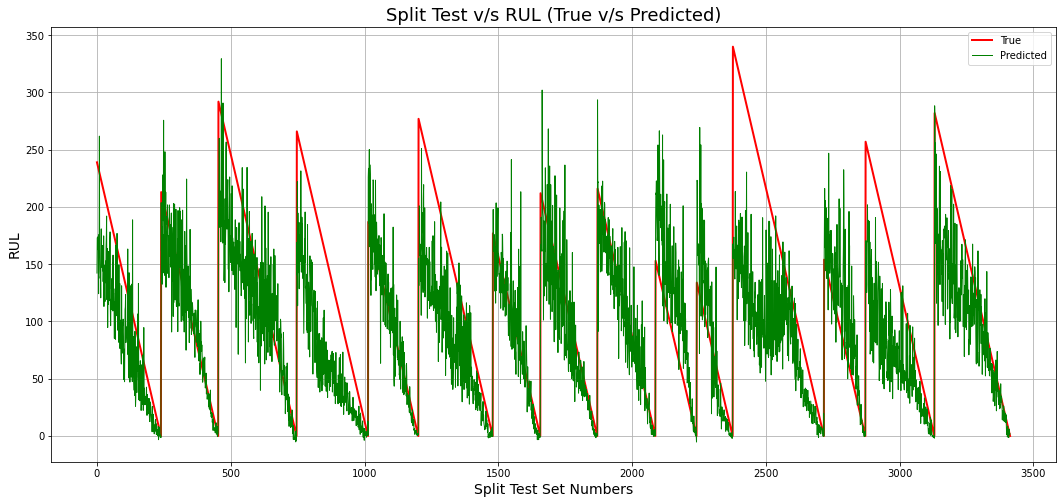

In [41]:
# Plot True RUL v/s Predicted RUL
def plot_prediction():
    plt.figure(figsize = (18, 8))
    plt.plot(validY, 'red', label = 'True', linewidth=2)
    plt.plot(y_predicted, 'green', label = 'Predicted', linestyle='-', linewidth=1)
    plt.xlabel('Split Test Set Numbers', fontdict={'fontsize':14})
    plt.ylabel('RUL', fontdict={'fontsize':14})
    plt.title('Split Test v/s RUL (True v/s Predicted)', fontdict={'fontsize':18})
    plt.legend()
    plt.grid(True)
    plt.show()
    return None

# Call
plot_prediction()

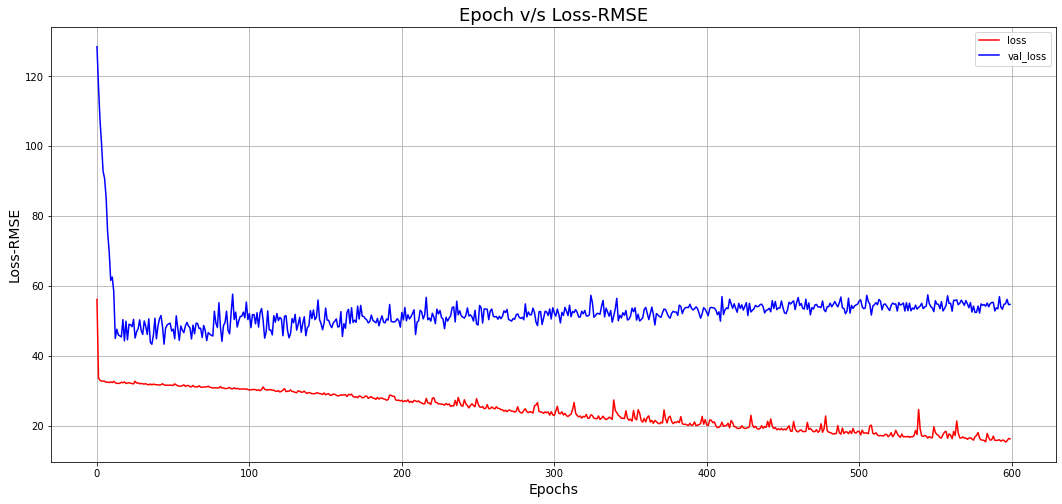

In [38]:
# Plot Loss
def plot_loss(history):
    plt.figure(figsize = (18, 8))
    plt.plot(history.history['loss'], color = 'red', label='loss')
    plt.plot(history.history['val_loss'], color = 'blue', label='val_loss')
    plt.ylabel('Loss-RMSE', fontdict={'fontsize':14})
    plt.xlabel('Epochs', fontdict={'fontsize':14})
    plt.title('Epoch v/s Loss-RMSE', fontdict={'fontsize':18})
    plt.grid(True)
    plt.legend()
    plt.show()
    return None

# Call
plot_loss(history)

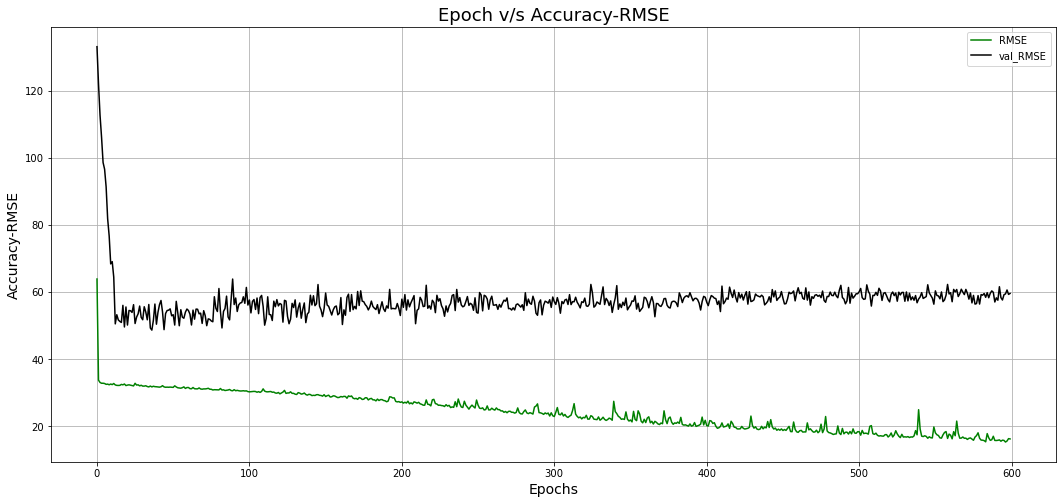

In [39]:
# Plot Accuracy
def plot_accuracy(history):
    plt.figure(figsize = (18, 8))
    plt.plot(history.history['root_mean_squared_error'], color = 'green', label='RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], color = 'black', label='val_RMSE')
    plt.ylabel('Accuracy-RMSE', fontdict={'fontsize':14})
    plt.xlabel('Epochs', fontdict={'fontsize':14})
    plt.title('Epoch v/s Accuracy-RMSE', fontdict={'fontsize':18})
    plt.grid(True)
    plt.legend()
    plt.show()
    return None

# Call
plot_accuracy(history)


### Predict the RUL of Test Set

Engine Number:  5
RMSE:  43.88896
True RUL:  91
Predicted RUL:  134.88896


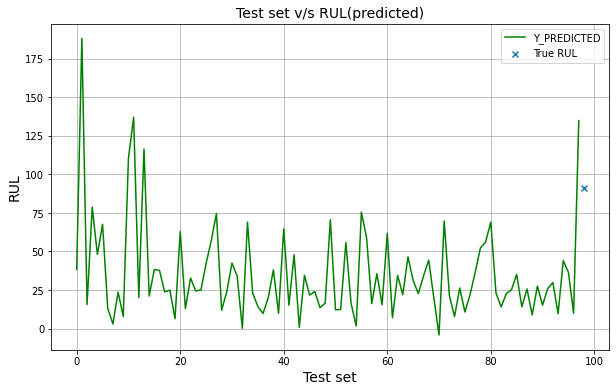

In [48]:
def test_predict(eng_number, testX):
    '''Predicts the Test Set RUL. Pass the Engine Number to be tested and 
       the data frame of test set i.e. testX.'''
    # Select the data with the given engine number
    print('Engine Number: ', eng_number)
    testX = sqldf(f'SELECT * FROM testX WHERE `ENGINE_NUMBER` == {str(eng_number)}')
    
    # Drop Engine Number column
    testX = testX.drop(labels = 'ENGINE_NUMBER', axis = 1, inplace = False)
#     print('Test X Shape: ', testX.shape)
    
    # Convert to Numpy array
    testX = np.asarray(testX, dtype = float)
    # Normalize
    testX = minmax_scale(testX)
    
    # Prepare the inputs to CNN and LSTM
    sample_size = testX.shape[0]
    time_steps = testX.shape[1]
    input_dimension = 1
    testX_CNN = testX.reshape(sample_size, time_steps, input_dimension)
    testX_LSTM = testX.reshape(sample_size , input_dimension, time_steps)
#     print('Reshaped TestX CNN: ', testX_CNN.shape)
#     print('Reshaped TestX LSTM: ', testX_LSTM.shape)
    
    # Predict Model
    y_predicted = model.predict(x=[testX_CNN, testX_LSTM])
    
    # True RUl
    rul = df_rul[0][eng_number-1]
    
    # Get the last value of y_predicted
    y_pred = y_predicted[-1][0]
    
    # Calculate RMSE 
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(rul, y_pred)
    print('RMSE: ', m.result().numpy())
    print('True RUL: ', rul)
    print('Predicted RUL: ', y_pred)
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(y_predicted, color = 'green', label='Y_PREDICTED')
    plt.scatter(testX.shape[0], rul, marker = 'x', label = 'True RUL')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Test set', fontdict={'fontsize':14})
    plt.ylabel('RUL', fontdict={'fontsize':14})
    plt.title('Test set v/s RUL(predicted)', fontdict={'fontsize':14})
    plt.show()

    return None

# Call
eng_number = 5
test_predict(eng_number, testX)

### Save Model

In [ ]:
tf.keras.models.save_model(model, 'Model_1.model', overwrite=True, include_optimizer=True)